In [30]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import pandas as pd
from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.parser import parse

In [56]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    x = df.ALL_INF
    #rolmean = pd.rolling_mean(timeseries, window=52)
    rolmean = pd.Series(x).rolling(window=52).mean()
    #rolstd = pd.rolling_std(timeseries, window=52)
    rolstd = pd.Series(x).rolling(window=52).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [2]:
df = pd.read_csv('C:/Users/blgai/OneDrive/Documents/School/SMU/Courses/Spring 2021/Quantifying The World/Case Study 8/data/flu_all_inf.csv', parse_dates=['EDATE'], index_col='EDATE')
df.head()

,ALL_INF
EDATE,
2013-01-06,6474
2013-01-13,6897
2013-01-20,5936
2013-01-27,5130
2013-02-03,4039


C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 1200x840 with 0 Axes>

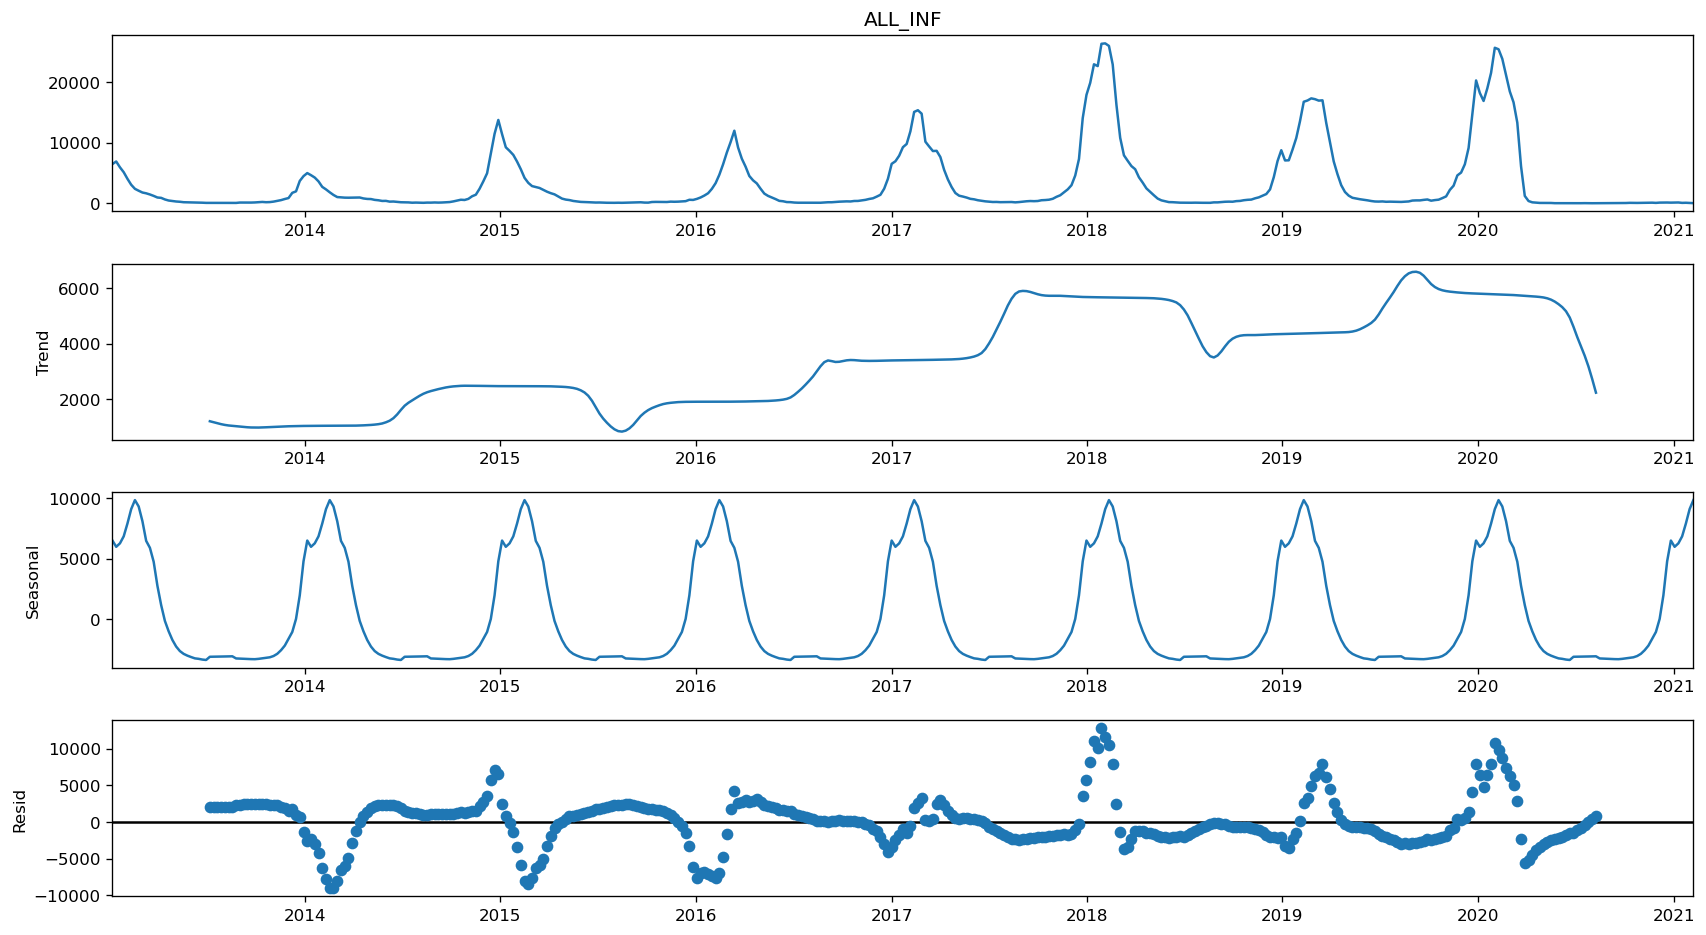

In [3]:
decomposition = seasonal_decompose(df.ALL_INF, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

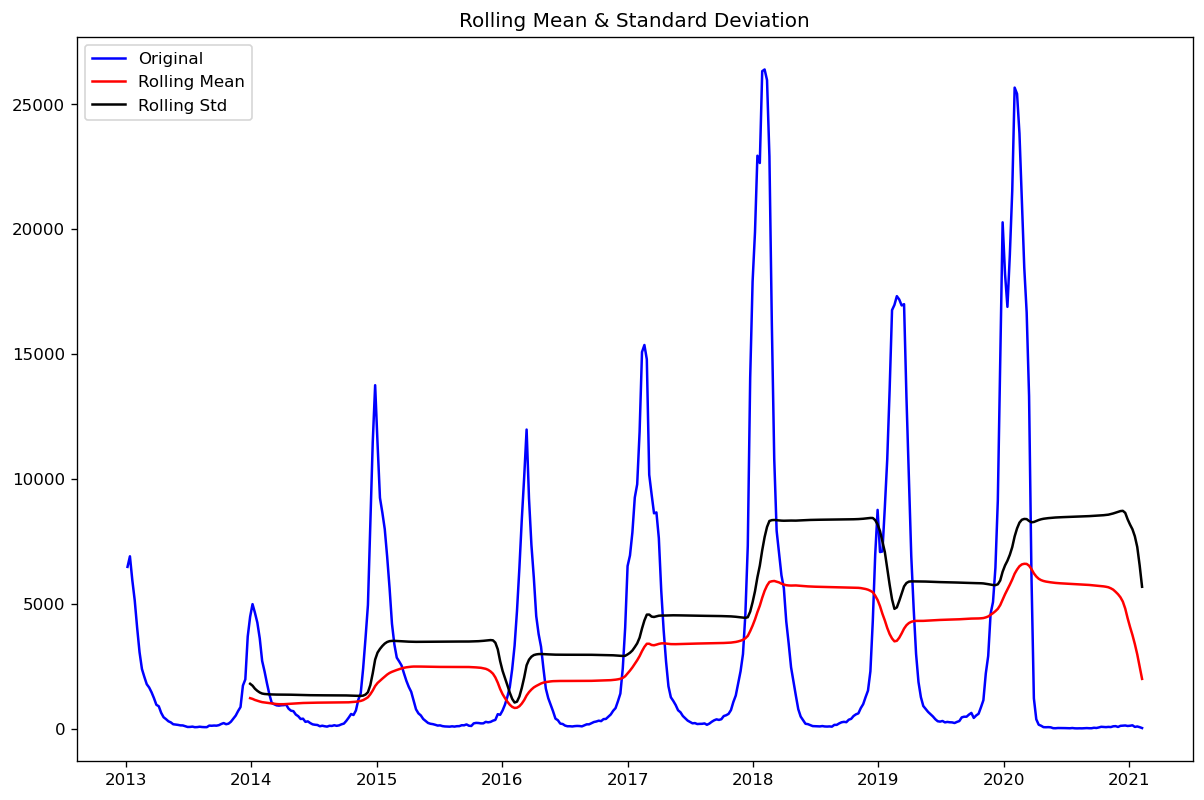

Results of Dickey-Fuller Test:
Test Statistic                  -5.118848
p-value                          0.000013
#Lags Used                      14.000000
Number of Observations Used    408.000000
Critical Value (1%)             -3.446480
Critical Value (5%)             -2.868650
Critical Value (10%)            -2.570557
dtype: float64


In [14]:
test_stationarity(df.ALL_INF)

Take out the seasonality and check that our data is stationary

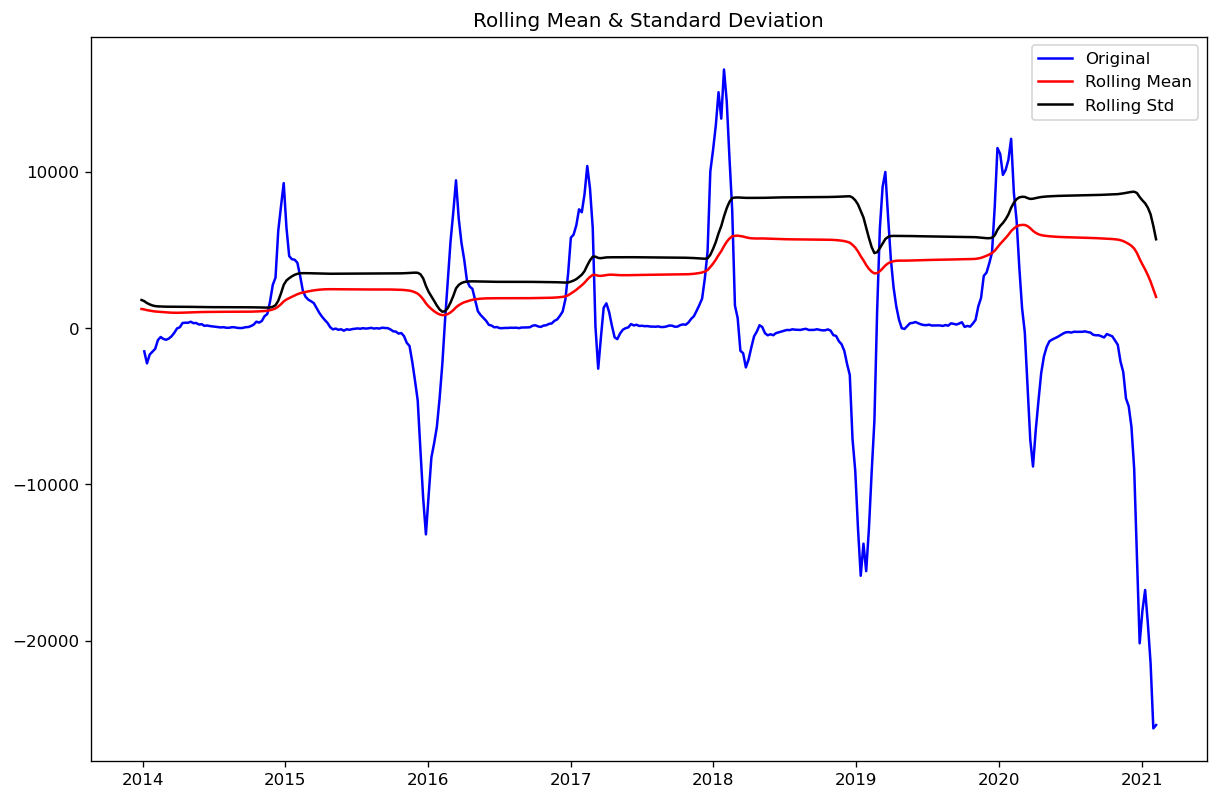

Results of Dickey-Fuller Test:
Test Statistic                  -3.318512
p-value                          0.014071
#Lags Used                       6.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


In [15]:
df['seasonal_difference'] = df.ALL_INF - df.ALL_INF.shift(52)
test_stationarity(df.seasonal_difference.dropna(inplace=False))

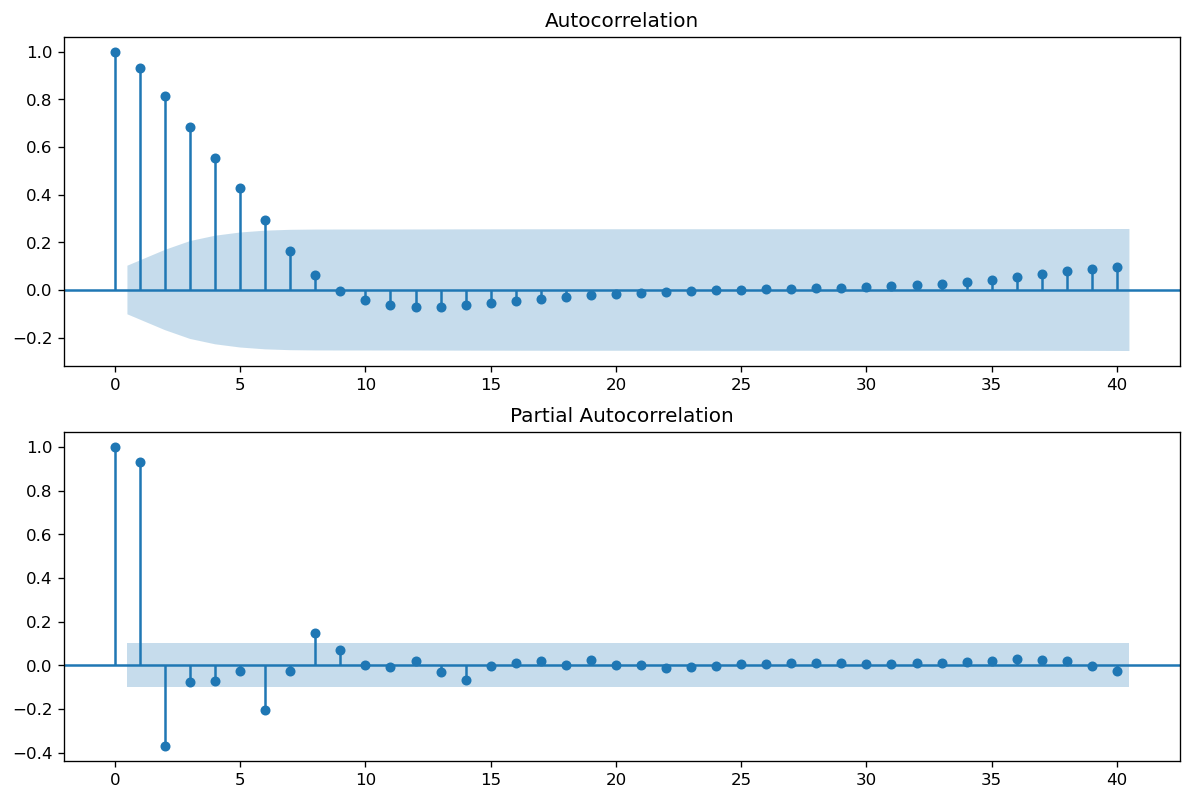

In [25]:
#plot ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df.seasonal_difference.iloc[53:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df.seasonal_difference.iloc[53:], lags=40, ax=ax2)

In [39]:
mod = sm.tsa.statespace.SARIMAX(df.ALL_INF, trend='n', order=(1,0,4), seasonal_order=(1,1,0,52))
results = mod.fit()
print(results.summary())

C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                             ALL_INF   No. Observations:                  423
Model:             SARIMAX(1, 0, 4)x(1, 1, [], 52)   Log Likelihood               -3091.042
Date:                             Sat, 20 Feb 2021   AIC                           6196.085
Time:                                     15:50:57   BIC                           6223.498
Sample:                                 01-06-2013   HQIC                          6206.973
                                      - 02-07-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8983      0.019     47.537      0.000       0.861       0.935
ma.L1          0.7161      

<AxesSubplot:xlabel='EDATE'>

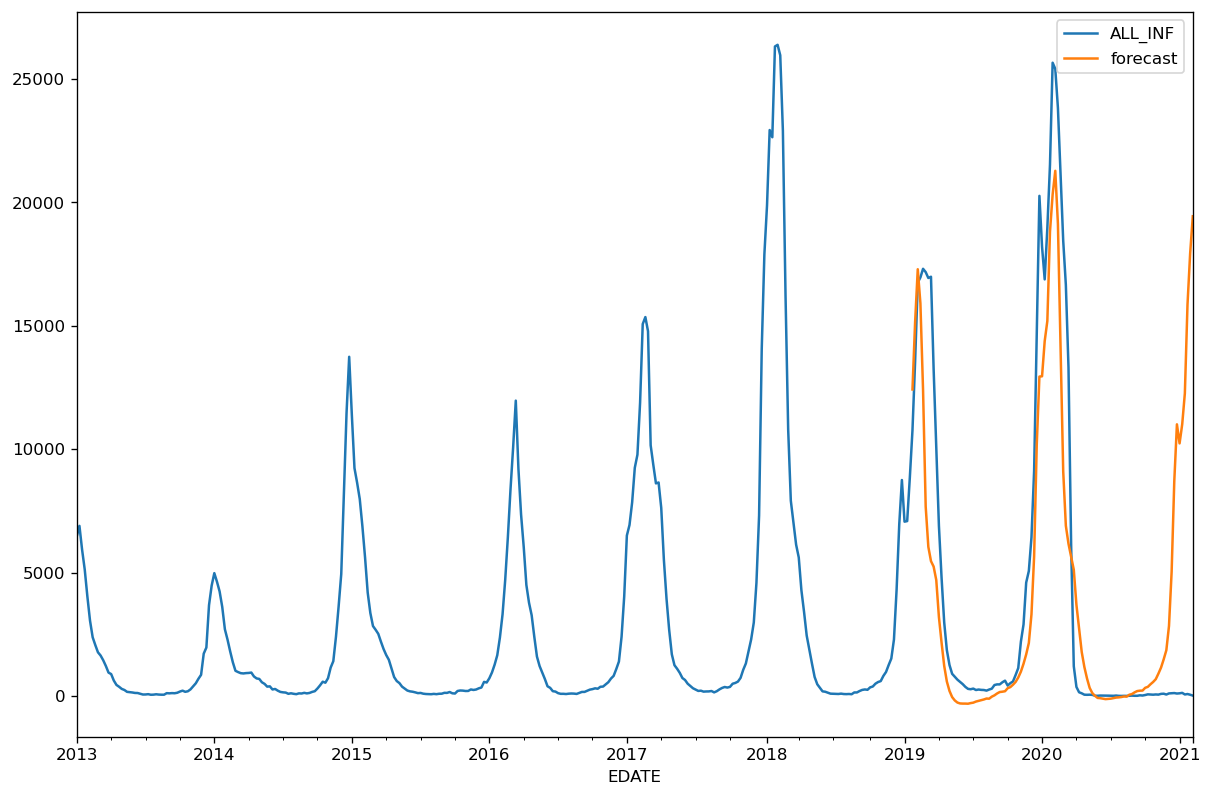

In [41]:
df['forecast'] = results.predict(start=316, end=423, dynamic=True)
df[['ALL_INF', 'forecast']].plot(figsize=(12,8))

In [54]:
#Create Training and Test
train = df.ALL_INF[:316]
test = df.ALL_INF[316:378]

C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                             ALL_INF   No. Observations:                  316
Model:             SARIMAX(1, 0, 4)x(1, 1, [], 52)   Log Likelihood               -2171.868
Date:                             Sat, 20 Feb 2021   AIC                           4357.736
Time:                                     16:11:53   BIC                           4382.768
Sample:                                 01-06-2013   HQIC                          4367.794
                                      - 01-20-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8522      0.022     37.936      0.000       0.808       0.896
ma.L1          0.7400      

C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2292: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


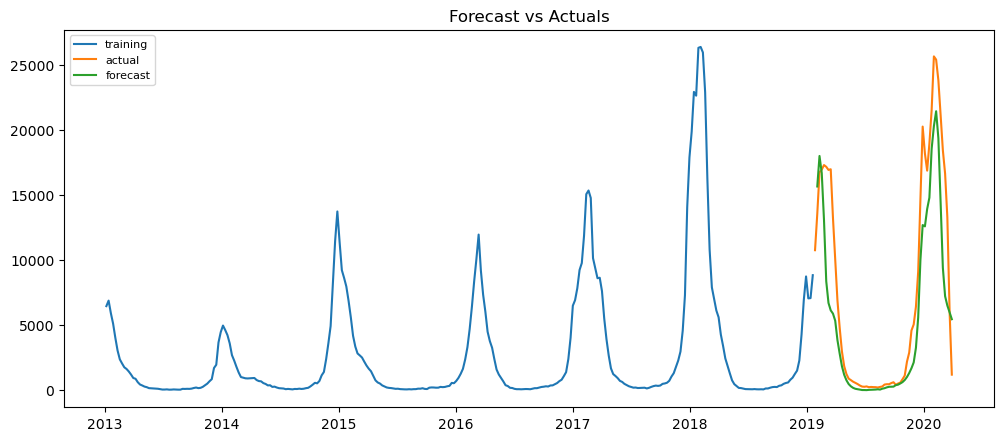

In [60]:
mod = sm.tsa.statespace.SARIMAX(df.ALL_INF[:316], trend='n', order=(1,0,4), seasonal_order=(1,1,0,52))
results = mod.fit()
print(results.summary())

fc = results.predict(start=317, end=378, dynamic=True)

fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [59]:
test.head()

EDATE
2019-01-27    10771
2019-02-03    13558
2019-02-10    16752
2019-02-17    16962
2019-02-24    17312
Name: ALL_INF, dtype: int64

In [61]:
forecast_accuracy(fc, test.values)

C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels.

{'mape': 0.49508825333293266,
 'me': -2395.23562432558,
 'mae': 2819.0220890343576,
 'mpe': -0.3876227713066516,
 'rmse': 4562.826778486626,
 'acf1': nan,
 'corr': 0.8892778439494503,
 'minmax': 0.464766962607144}